In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/Documents/AlgebraicJulia/CANMOD-2022/notebooks`


In [101]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.WiringDiagrams, Catlab.Programs, Catlab.Graphics
using AlgebraicPetri

draw(uwd::AbstractUWD; kwargs...) = to_graphviz(uwd, junction_labels=:variable, box_labels=:name; kwargs...);

# Composing Petri Nets

## A first example - SIR
Here we construct an SIR model as the composition of an infection process and a recovery process. 

### The interaction pattern

For composing Petri nets the interaction pattern is given by an undirected wiring diagram (UWD). As a $\mathcal{C}\mathsf{-Set}$ a UWD has the schema:

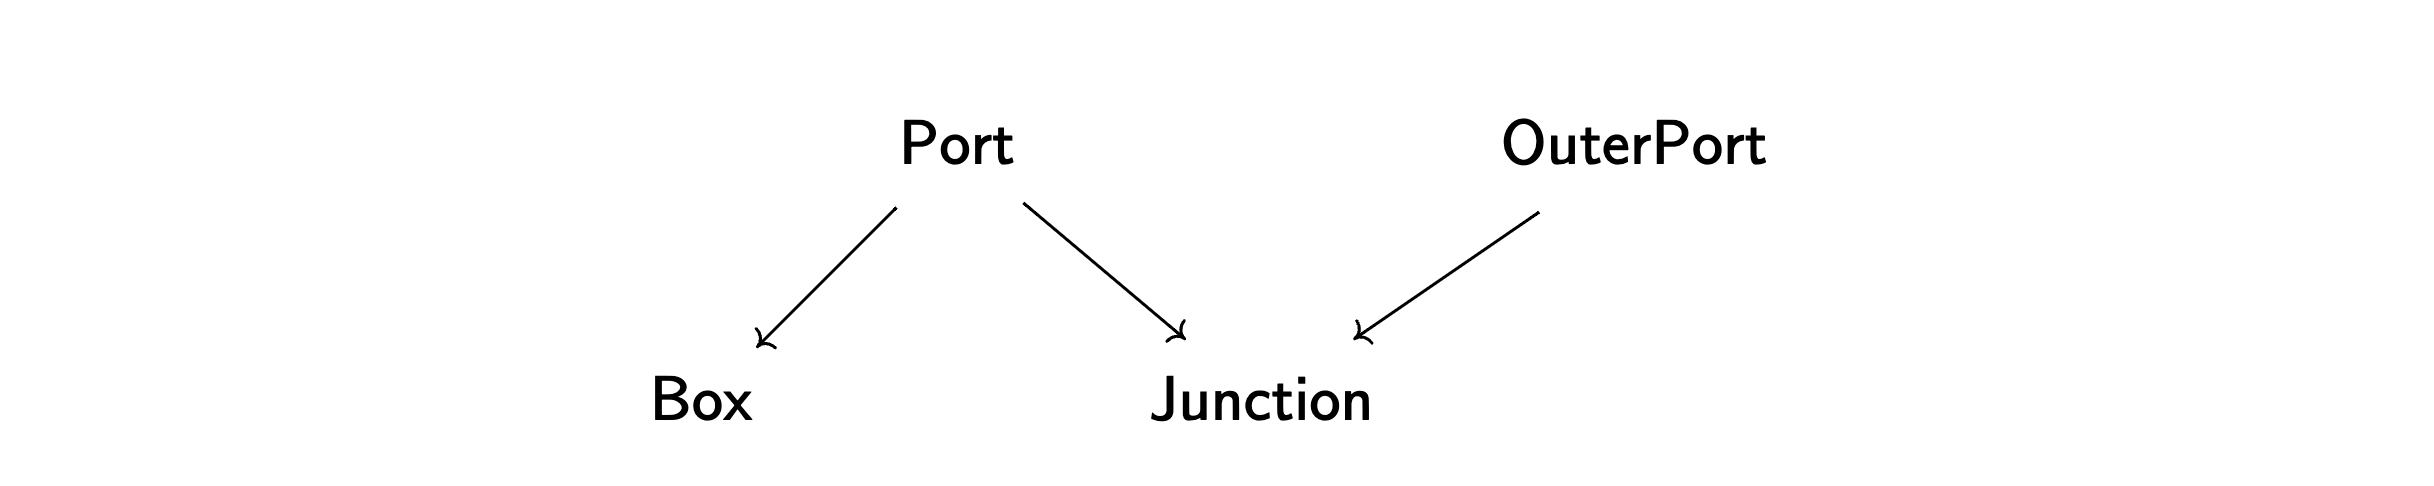

However, in Catlab we can use the `@relation` macro to define the UWD. 

In [88]:
interaction_pattern = @relation (S, I, R) begin 
    infection(S, I)
    recovery(I, R)
end

Catlab.Programs.RelationalPrograms.UntypedUnnamedRelationDiagram{Symbol, Symbol} with elements Box = 1:2, Port = 1:4, OuterPort = 1:3, Junction = 1:3
┌─────┬───────────┐
│ Box │      name │
├─────┼───────────┤
│   1 │ infection │
│   2 │  recovery │
└─────┴───────────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   2 │        2 │
│    4 │   2 │        3 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
│         3 │              3 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        S │
│        2 │        I │
│        3 │        R │
└──────────┴──────────┘

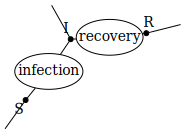

In [89]:
draw(interaction_pattern)

### The component models

Next we define two open Petri nets that "fill" the infection and recovery boxes.

interface type: 2

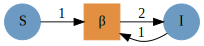

In [90]:
inf_net = LabelledPetriNet([:S, :I],
    :β => ((:S, :I) => (:I, :I))
)

open_inf = Open(inf_net, [:S], [:I])

print("interface type: ", length(legs(open_inf)))
Graph(open_inf)

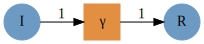

In [91]:
rec_net = LabelledPetriNet([:I, :R],
    :γ => (:I => :R)
)

open_rec = Open(rec_net, [:I], [:R])

Graph(open_rec)

### Compose!

Finally, we compose the component models `open_inf` and `open_rec` using the UWD `interaction_pattern`. Graphing the result we indeed get the SIR model. 

interface type: 3

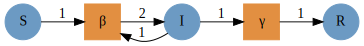

In [92]:
sir = oapply(interaction_pattern, Dict([
            :infection => open_inf, 
            :recovery => open_rec
]));

print("interface type: ", length(legs(sir)))
Graph(sir)

## Independence of syntax and semantics

One of the advantages of compositional modeling using operad algebras is that you can adjust the semantics (the choice of component models) and syntax (the choice of interaction pattern) independently. 

### Change the semantics

Consider replacing the component infection model with an SEI model that accounts for incubation. 

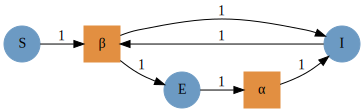

In [93]:
sei_net = LabelledPetriNet([:S, :E, :I],
    :β => ((:S, :I) => (:E, :I)),
    :α => (:E => :I)
)

open_sei = Open(sei_net, [:S], [:I])

Graph(sei_net)

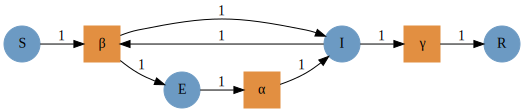

In [94]:
seir = oapply(interaction_pattern, Dict([
            :infection => open_sei, 
            :recovery => open_rec
]));

Graph(seir)

### Change the syntax

On the other hand consider changing the interaction pattern so that the recovered population is identified with the susceptible population. This adjustment leads to an SIS model of infection. 

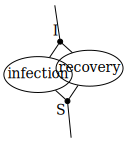

In [95]:
sis_interaction = @relation (S, I) begin 
    infection(S, I)
    recovery(I, S)
end

draw(sis_interaction)

In [96]:
open_rec_unlabelled = Open(PetriNet(rec_net), [1], [2]);
open_inf_unlabelled = Open(PetriNet(inf_net), [1], [2]);

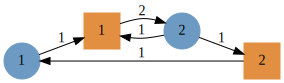

In [97]:
sis = oapply(sis_interaction, Dict([:infection => open_inf_unlabelled, :recovery => open_rec_unlabelled]));

Graph(sis)

## A second example - SVIIvR

In this example, we specify a SVIIvR disease model as the composition of three submodels:

- An SIR model for unvaccinated individuals.
- An SIR model for vaccinated individuals (which we call the VIvR model).
- A cross-exposure model which dictates the interactions between unvaccinated and vaccinated individuals.

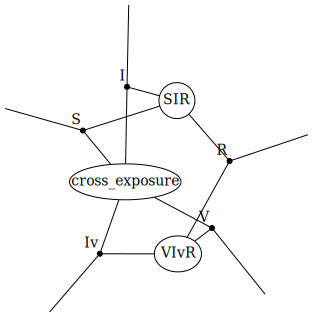

In [102]:
SVIIvR_composition_pattern = @relation (S, V, I, Iv, R) where (S, V, I, Iv, R) begin
  SIR(S, I, R)
  VIvR(V, Iv, R)
  cross_exposure(S, I, V, Iv)
end

draw(SVIIvR_composition_pattern, edge_attrs=Dict(:len => "1"))

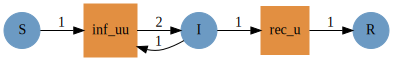

In [103]:
SIR = Open(LabelledPetriNet([:S, :I, :R],
  :inf_uu => ((:S, :I) => (:I, :I)),
  :rec_u => (:I => :R)
))

Graph(SIR)

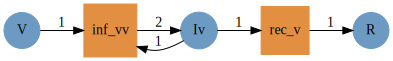

In [104]:
VIvR = Open(LabelledPetriNet([:V, :Iv, :R],
  :inf_vv => ((:V, :Iv) => (:Iv, :Iv)),
  :rec_v => (:Iv => :R)
))

Graph(VIvR)

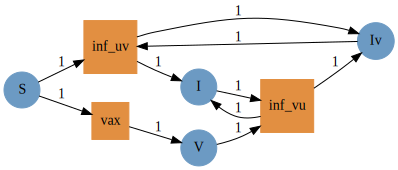

In [105]:
cross_exposure = Open(LabelledPetriNet([:S, :I, :V, :Iv],
  :inf_uv => ((:S, :Iv) => (:I, :Iv)),
  :inf_vu => ((:V, :I) => (:Iv, :I)),
  :vax => (:S => :V)
))

Graph(cross_exposure)

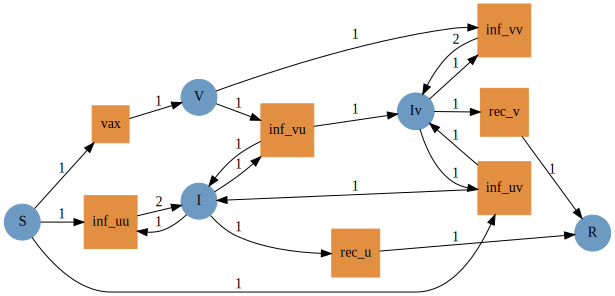

In [106]:
SVIIvR = oapply(SVIIvR_composition_pattern, Dict(
  :SIR => SIR,
  :VIvR => VIvR,
  :cross_exposure => cross_exposure
))

Graph(SVIIvR)

## Your turn!

### Option 1 - Lotka-Volterra predator prey model

Construct the Lotka-Volterra predator prey model as the composite of:
- A model of rabbit growth.
- A predation model.
- A model of fox decline.

### Option 2 - Infection and vaccination model

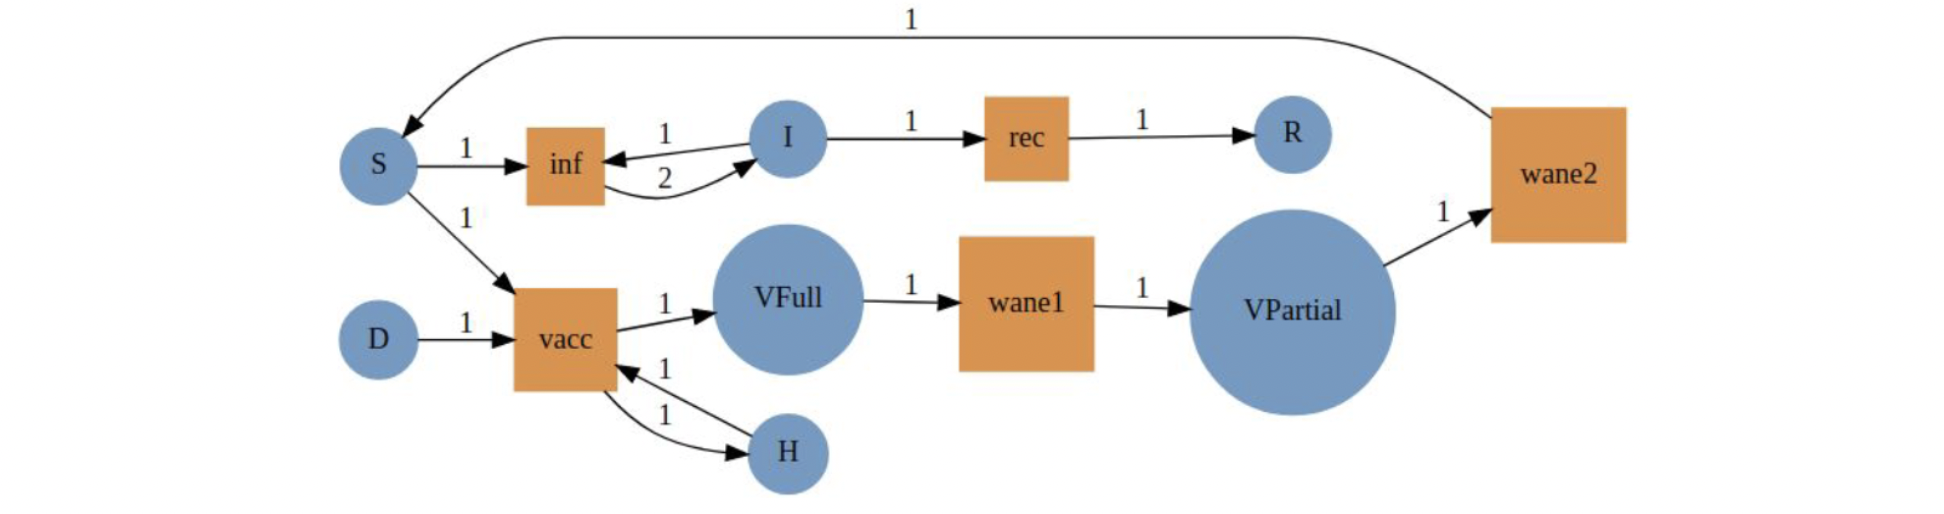

Construct the  Petri net above as the composite of:

- An SIR model.
- A vaccination model.
- A model of waning of immunity.

Bonus: Adjust the semantics independent of the syntax. For example, replace the SIR model with a different infection model. Or change the waning of immunity model to have more or fewer stages.